In [286]:
import pandas as pd
import numpy as np
from scipy.stats import weibull_min
import math
import random
import matplotlib.pyplot as plt
from random_word import RandomWords

In [6]:
# GLOBAL VARIABLES
STAGES = ['VALIDATING', 'RECRUITING', 'BUILDING', 'PRESEEDING', 'SEEDING']
SUBSTAGES = [['added_to_backlog']
            , ['validation_start', 'validation_present_to_fund', 'fir_approved_or_killed']
            , ['fir_jd_posted', 'fir_accepted_or_killed']
            , ['fir_start', 'build_present_to_fund', 'funding_approved_or_killed']
            , ['pre_seed_funded'], ['seed_funded']]

BUILDER_NAMES = ['RC', 'KB', 'BZ']
BUILDER_CAPACITY = [2,100,2,100,100]

# conversion_seeds
CONVERSION_MEAN = [0.36, 0.84, 0.50, 1.0, 1.0]
DURATION_MEAN = [20, 58, 93, 40, 270]
DURATION_SHAPE = [1.29, 1.29, 1.35, 1.29, 1.29]
# duration calculations require a weibull distribution (np.random.weibull(shape))

# objectives
CONVERSION_OBJECTIVES = [0.50, 1.0, 0.67, 1.0, 1.0]
DURATION_OBJECTIVES = [14, 60, 90, 30, 270]

## Vectorizing project creation
Each project (row) has 5 stages, with a duration in each stage.

In [477]:
# Instatiating 1000 projects
P = 10

### Calculating durations and conversions

In [478]:
# Creates matrix of shape (1000, 5) filled with projected durations by stage
# Instead of random durations, we project duration by stage using a Weibull distribution with shape = 1.29
durations = (np.random.weibull(1.29, P*5).reshape(P,5)*DURATION_MEAN).astype(int)

# Sometimes, stage 1 durations are initialized as a decimal, which is truncated to a 0. Change those to a floor of 1.
durations[:, 0] = np.where(durations[:,0] == 0, 1, durations[:,0])

In [479]:
df = pd.DataFrame(durations)

In [480]:
# Creates matrix of shape (1000, 5) filled with random decimals
# If decimal is less than expected conversion rate, that counts as a conversion (1)
original_conversions = (np.random.rand(1, P*5).reshape(P,5)<=CONVERSION_MEAN).astype(int)

# If a project fails in stage i, it must be marked as failed in stages i through n.
# Iterates through conversion matrix, modifies future stages as failed if ANY preceding stage failed.
ccopy = original_conversions.copy()
for i in range(1, 5):
    ccopy[:, i] = original_conversions[:, 0:i+1].all(axis=1)
    
conversions = ccopy

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>, <AxesSubplot:>]], dtype=object)

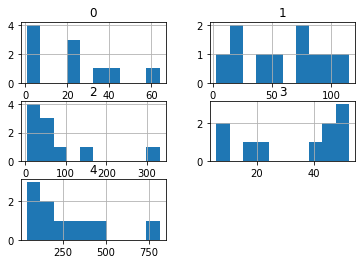

In [481]:
df.hist()

### Creating the roadmap

- The conversions matrix has the outcome in each stage, but a Builder would still work on that project until it was killed
- Before calculating the actual durations, we have to apply a mask to the original conversions table.
- This mask is effectively an indicator of whether or not any work was done during that stage.

In [482]:
active_stages = np.concatenate((np.ones([conversions.shape[0],1]), conversions.copy()),axis=1).astype(int)
active_stages = active_stages[:, 0:5]

In [483]:
active_stages

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

Element-wise multiplication of the randomly generated 'durations' and active_stages arrays gives us the actual simulated time on each project.

In [484]:
actual_durations = durations*active_stages

In [485]:
pd.DataFrame(actual_durations)

,0,1,2,3,4
0,38,0,0,0,0
1,64,0,0,0,0
2,20,0,0,0,0
3,7,115,35,0,0
4,3,0,0,0,0
5,1,24,50,43,438
6,25,0,0,0,0
7,42,47,33,8,408
8,5,0,0,0,0
9,20,0,0,0,0


## Converting projects roadmap to tasks

We can now create individualized 'tasks' that each of these stages represent, which will later be allocated to builder resources.

In [486]:
import simpy

In [487]:
validator = simpy.Resource(env, capacity=2)
builder = simpy.Resource(env, capacity=2)

def print_stats(b):
    print(f'{b.count} of {b.capacity} slots are allocated.')
    print(f'  Projects: {b.users}')
    print(f'  In Queue: {b.queue}')

def user(b):
    print_stats(b)
    with b.request() as req:
        yield req
        print_stats(b)
    print_stats(b)

procs = [env.process(user(builder)), env.process(user(builder))]
env.run()

0 of 2 slots are allocated.
  Projects: []
  In Queue: []
1 of 2 slots are allocated.
  Projects: [<Request() object at 0x7fa7e827d550>]
  In Queue: []
2 of 2 slots are allocated.
  Projects: [<Request() object at 0x7fa7e827d550>, <Request() object at 0x7fa7e8261f90>]
  In Queue: []
1 of 2 slots are allocated.
  Projects: [<Request() object at 0x7fa7e8261f90>]
  In Queue: []
1 of 2 slots are allocated.
  Projects: [<Request() object at 0x7fa7e8261f90>]
  In Queue: []
0 of 2 slots are allocated.
  Projects: []
  In Queue: []


In [488]:
class Studio(object):
    """A carwash has a limited number of machines (``NUM_MACHINES``) to
    clean cars in parallel.

    Cars have to request one of the machines. When they got one, they
    can start the washing processes and wait for it to finish (which
    takes ``washtime`` minutes).

    """
    def __init__(self, env, num_validators, num_builders):
        self.env = env
        self.validators = simpy.Resource(env, num_validators)
        self.builders = simpy.Resource(env, num_builders)

    def validate(self, name, duration, outcome):
        """The validation process.."""
        yield self.env.timeout(duration)
        if outcome == 0:
            print('Project %s did not pass Validation. Shelving.' % name)
        else:
            print("Project %s passed Validation. Proceeding to Recruitment." % name)
    
    def recruit(self, name, duration, outcome):
        """The recruitment process.."""
        yield self.env.timeout(duration)
        if outcome == 0:
            print('Project %s did not pass Recruitment. Shelving.' % name)
        else:
            print("Project %s passed Recruitment. Proceeding to Build." % name)
    
    def build(self, name, duration, outcome):
        """The build process.."""
        yield self.env.timeout(duration)
        if outcome == 0:
            print('Project %s did not pass Build. Shelving.' % name)
        else:
            print("Project %s passed Build. Proceeding to Pre-seed." % name)
            
    def preseed(self, name, duration, outcome):
        """The pre-seeding process.."""
        yield self.env.timeout(duration)
        if outcome == 0:
            print('Project %s did not receive Pre-Seed funding. Shelving.' % name)
        else:
            print("Project %s received Pre-Seed funding at time %d. Proceeding to Seed." % name, env.now)
    
    def seed(self, name, duration, outcome):
        """The seeding process.."""
        yield self.env.timeout(duration)
        if outcome == 0:
            print('Project %s did not receive Seed funding. Shelving.' % name)
        else:
            print("Project %s received Seed funding." % name)

In [495]:
def project(env, studio, name, durations, outcomes):
    print('Project %s on deck at time %d' % (name, env.now))
    with studio.validators.request() as request:
        yield request
        print('Project %s beginning validation at time %d' % (name, env.now))
        yield env.process(studio.validate(name))
    if conversions[1] == 1:
        print('Project %s beginning recruitment at time %d' % (name, env.now))
        yield env.process(studio.recruit(name))
    with studio.builders.request() as request:
        if outcomes[2] == 1:
            print('Project %s beginning build at time %d' % (name, env.now))
            yield env.process(studio.build(name))
    if outcomes[3] == 1:
        print('Project %s beginning pre-seed at time %d' % (name, env.now))
        yield env.process(studio.preseed(name))
    if outcomes[4] == 1:
        print('Project %s beginning seed at time %d' % (name, env.now))
        yield env.process(studio.seed(name))

In [496]:
def setup(env, num_validators, num_builders):
    """Create a carwash, a number of initial cars and keep creating cars
    approx. every ``t_inter`` minutes."""
    # Create the carwash
    studio = Studio(env, num_validators, num_builders)
    
    # Create 4 initial cars
    for i in range(len(durations)):
        env.process(project(env, studio, 'Project ID%d' % i, durations[i], conversions[i]))

In [497]:
print('Studio')
random.seed(42)  # This helps reproducing the results

# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, 3, 3))

# Execute!
env.run(until=100)

Studio


ValueError: None is not a generator.

In [436]:
backlog = actual_durations

In [456]:
builder = {
    'projectHistory': [[]],
    'activeProjects': [[],[],[],[],[]],
    'hasValidationCapacity': False,
    'hasBuildingCapacity': False
}

In [461]:
def check_capacity(stage):
    actives = len(builder['activeProjects'][stage])
    return (actives < BUILDER_CAPACITY[stage], BUILDER_CAPACITY[stage]-actives)

In [462]:
check_capacity(0)

(True, 2)

In [ ]:
backlog_index = 0

while current_time < end_time:
    print('Time = %d' % current_time)
    print('Checking builder capacity for new projects...')
    while check_capacity[stage=0]:
        project = backlog[backlog_index]
        builder[0].append(project)
        print('Added project.')
        backlog_index+=1
        project['roadmap'] = project['duration']+current_time
    print('Builder validation capacity reached.')
    
    print('Checking project status by stage...'
    for stage in builder:
          for project in stage:
              

In [388]:
class Project:
    def __init__(self, name, builder, category, project_start, active_stage):
        self.name = name
        self.builder = builder
        self.category = category
        self.project_start = project_start
        self.turns_delayed = [0]*5
        self.active_stage = active_stage
        # active_stage is an integer from 1 to 5
        
        self.project_history = [{'start': 0, 'end': 0, 'outcome': 0}
                                , {'start': 0, 'end': 0, 'outcome': 0}
                                , {'start': 0, 'end': 0, 'outcome': 0}
                                , {'start': 0, 'end': 0, 'outcome': 0}
                                , {'start': 0, 'end': 0, 'outcome': 0}]
        # stage_history is a nested array showing the start_date, end_date, and stage outcome
        ## stage outcomes are [-1, 0, 1] - killed, not started or in progress, converted
        
    def generate_report(self):
        print(self.name, ">>")
        print('Builder: ', self.builder.name)
        print('Project Start: ', self.project_start)
        print('Project History: ')
        print(self.project_history)
        
    def calc_durations(self):
        duration_weibulls = []
        for i in range(len(DURATION_MEAN)):
            duration_weibulls.append(np.random.weibull(DURATION_SHAPE[i]))
        
        durations = [int(dw * DM) for dw, DM in zip(duration_weibulls, DURATION_MEAN)]
        return durations
    
    def calc_conversions(self):
        conversions = []
        outcomes = []
        for i in range(len(CONVERSION_MEAN)):
            conversions.append(random.randint(0,100)/100.0)
            outcomes.append(conversions[i] <= CONVERSION_MEAN[i])
        
        for o in range(len(outcomes)):
            if outcomes[o] == False:
                outcomes[o:]=[False]*(len(outcomes)-o)
                break
                
        return outcomes
    
    def delay_project(self, stage):
        self.turns_delayed[stage] += 1
        for i in range(stage+1, 5):
            self.project_history[i]['start']+=1
            self.project_history[i]['end']+=1
        
    def execute_project(self, start_date):
        # Be sure to set the project_start variable to the current turn before executing!
        self.project_start = start_date
        
        outcomes = self.calc_conversions()
        durations = self.calc_durations()
        
        # modify durations if project was killed
        stage_killed = -1
        try:
            stage_killed = outcomes.index(False)
        except:
            pass
        
        if stage_killed != -1:
            durations[stage_killed+1:] = [0]*(len(outcomes)-stage_killed)
        
        # end_dates = cumulative sum of stage durations
        stage_ends = list(np.cumsum(durations))
        stage_starts = [stage_ends[i] - durations[i] for i in range(len(stage_ends))]
        
        # add all fields to stage_history
        for stage in range(len(self.project_history)):
            self.project_history[stage]['start'] = stage_starts[stage]
            self.project_history[stage]['end'] = stage_ends[stage]
            self.project_history[stage]['outcome'] = outcomes[stage]
        #self.project_report()

In [389]:
class Builder:
    def __init__(self, name):
        self.name = name
        self.active_projects = [[],[],[],[],[]]
        self.completed_projects = [[],[],[],[],[]]
        self.killed_projects = [[],[],[],[],[]]
        
    def current_projects(self,stage=None):
        if stage==None:
            return self.active_projects()
        else:
            return self.active_projects[stage]
    
    def has_capacity(self, stage):
        print('stage', stage)
        active_projects = self.active_projects[stage]
        num_active_projects = len(active_projects)
        slots_available = BUILDER_CAPACITY[stage] - num_active_projects
        print('** %s inventory: [%d|%d]' % (self.name, num_active_projects, BUILDER_CAPACITY[stage]))
        return slots_available > 0
    
    def update_project(self, project, current_turn):
        # If current_turn is greater than end date of current stage, attempt to convert
        from_stage = project.active_stage
        to_stage = from_stage+1
        
        if project.project_history[from_stage]['end'] >= current_turn:
            if project.project_history[from_stage]['outcome'] == 1:
                if to_stage < 5:
                    if self.has_capacity(to_stage):
                        project.active_stage = to_stage
                        self.active_projects[to_stage].append(project)
                        self.active_projects[from_stage].remove(project)
                        self.completed_projects[from_stage].append(project)
                        print('Project proceeded to next stage.')
                    else:
                        print('Builder does not have capacity to add project. Project delayed by 1 turn.')
                        project.delay_project(from_stage)
                else:
                    print('Project completed.')
                    self.completed_projects[from_stage].append(project)
                    self.active_projects[from_stage].remove(project)
                    
            else:
                self.killed_projects[from_stage].append(project)
                self.active_projects[from_stage].remove(project)
                print('Project killed.')
    
    def builder_report(self):
        print(self.name)
        for i in range(1, 5):
            if len(self.active_projects[i]) > 0:
                print('Stage {}: '.format(i), [p.name for p in self.active_projects[i]])
        print()

In [390]:
class Studio:
    def __init__(self, builder, backlog=[]):
        self.builder = builder
        self.backlog = backlog
        
    def add_to_backlog(self, num_ideas):
        for i in range(num_ideas):
            project = Project(rw.get_random_word(), self.builder, category="B", project_start=1, active_stage=1)

    def take_from_backlog(self, num_projects, stage):
        selected_projects = [p for p in self.backlog if p.active_stage == stage][:num_projects]
        if len(selected_projects) == 0:
            print('** Studio has no projects in Stage %d to assign at this time.' % (stage))
        return selected_projects
    
    def process_turn(self, current_date):
        print('Turn: %d' % (current_date))
        print('*'*8)
        for stage in range(len(STAGES)-1):
            print('* In Stage %d' % (stage))
            # If builder has capacity, add projects from backlog to their inventory
            slots = BUILDER_CAPACITY[stage] - len(self.builder.active_projects[stage])
            if slots > 0:
                # Add available projects to builder's active_projects inventory in this stage, until full
                selected_projects = self.take_from_backlog(slots, stage)
                if len(selected_projects) != 0:
                    # Change start dates in selected projects to current date before assignment
                    for project in selected_projects:
                        project.execute_project(current_date)
                        print('*** Assigned Project %s to Builder %s.' % (project.name, self.builder.name))
                        self.builder.active_projects[stage].append(project)
                        self.backlog.remove(project)

            # prints any active projects in that stage
            for project in self.builder.active_projects[stage]:
                print('* Project %s progress: %d of %d' % (project.name, current_date, project.project_history[stage]['end']))

            # Check builder inventory for any projects that are transitioning to the next stage during this turn
            for project in self.builder.active_projects[stage]:
                self.builder.update_project(project, current_date)
                

In [391]:
'''
Step 1: Create Studio with a Builder
Step 2: Add n randomly generated projects to backlog
Step 3: Add p projects to Builder slots until capacity met
Step 4: Execute p projects with project_start = current_turn
Step 5: Increment through turns:
- 5a: Add available projects in backlog to Builder inventory
- 5b: For each project in Builder active project inventory:
    - 5c: If current_turn == stage_history[active_stage][end_date], AND project not killed, then change active_stage to next stage
    - 5d: If project was killed, remove from Builder active_projects inventory and add to Builder killed_projects

'''
'''
Create an environment with a Studio ("AIVM"), a Builder ('Ryan Cunningham'), and randomly generated Projects.
In each time step:
- Check builder capacity for additional projects in each stage
- Add projects if capacity is available
- Change project statuses if project converts to the next stage in that time step

Track project completions, kills, and builder utilization by time step.
'''

'\nCreate an environment with a Studio ("AIVM"), a Builder (\'Ryan Cunningham\'), and randomly generated Projects.\nIn each time step:\n- Check builder capacity for additional projects in each stage\n- Add projects if capacity is available\n- Change project statuses if project converts to the next stage in that time step\n\nTrack project completions, kills, and builder utilization by time step.\n'

In [392]:
ryan = Builder('Ryan')
aivm = Studio(ryan)
rw = RandomWords()

In [393]:
aivm.backlog = [Project(rw.get_random_word(), ryan, category="B", project_start=1, active_stage=1) for i in range(10)]

In [395]:
# Environment
current_turn = 1
max_turns = 100

while(current_turn <= max_turns):
    aivm.process_turn(current_turn)
    current_turn += 1

Turn: 1
********
* In Stage 0
** Studio has no projects in Stage 0 to assign at this time.
* In Stage 1
*** Assigned Project permissively to Builder Ryan.
*** Assigned Project unlistenably to Builder Ryan.
*** Assigned Project orillion to Builder Ryan.
*** Assigned Project forwarded to Builder Ryan.
*** Assigned Project None to Builder Ryan.
*** Assigned Project Unitas to Builder Ryan.
*** Assigned Project instinct to Builder Ryan.
*** Assigned Project subkingdoms to Builder Ryan.
*** Assigned Project claustrophobes to Builder Ryan.
*** Assigned Project tangy to Builder Ryan.
* Project permissively progress: 1 of 11
* Project unlistenably progress: 1 of 11
* Project orillion progress: 1 of 21
* Project forwarded progress: 1 of 17
* Project None progress: 1 of 35
* Project Unitas progress: 1 of 65
* Project instinct progress: 1 of 15
* Project subkingdoms progress: 1 of 8
* Project claustrophobes progress: 1 of 47
* Project tangy progress: 1 of 38
Project killed.
Project killed.
Project

In [396]:
len(ryan.active_projects)

5

In [60]:
ryan.active_projects

{1: [[<__main__.Project at 0x7f92ea82e7d0>,
 2: [[], []],
 3: [[], [], [], [], [], [], [], [], [], []],
 4: [[], [], [], [], [], [], [], [], [], []],
 5: []}

In [9]:
a_list = ['This', 'is', 'a', 'test']

In [10]:
b = [a = 'Changed' for a in a_list]

SyntaxError: invalid syntax (736645213.py, line 1)

TypeError: unsupported operand type(s) for *: 'dict' and 'int'